This notebook demonstrates the use of our linear approximation for sensitivity with respect to the Dirichlet process $\alpha$ parameter

In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

from numpy.polynomial.hermite import hermgauss

import paragami

# BNP sensitivity libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib

from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
import bnpgmm_runjingdev.utils_lib as utils_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import time

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)

features = np.array(features)

Text(0, 0.5, 'PC2')

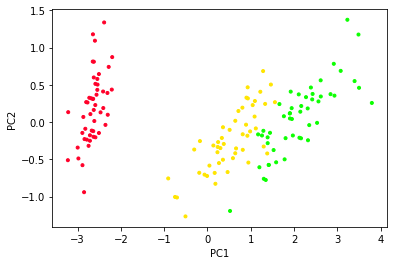

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [4]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = 3.5
print(prior_params_dict)

{'alpha': 3.5, 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_lambda': DeviceArray([1.], dtype=float64), 'prior_wishart_df': DeviceArray([10.], dtype=float64), 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float64)}


### Variational parameters

In [5]:
# number of clusters in variational distribution 
k_approx = 30

In [6]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

# convert to jax arrays
gh_loc, gh_weights = np.array(gh_loc), np.array(gh_weights)

In [7]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [8]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

DeviceArray(1639.2632694, dtype=float64)

# Optimize KL objective

### Initialize with K-means

In [9]:
# run a kmeans init
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                  seed = 453453)

print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
4855.740571596976


In [10]:
vb_params_dict = init_vb_params_dict

### Run CAVI

In [11]:
x_tol = 1e-3
vb_opt_dict, e_z_opt = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False, 
                                            x_tol = x_tol)

Compiling CAVI update functions ... 
CAVI compile time: 7.16sec

Running CAVI ... 
done. num iterations = 94
stick_time: 1.28sec
cluster_time: 1.19sec
e_z_time: 0.0372sec
**CAVI time: 2.72sec**


In [12]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

### Check results

In [13]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]
    
    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])


Text(0, 0.5, 'PC2')

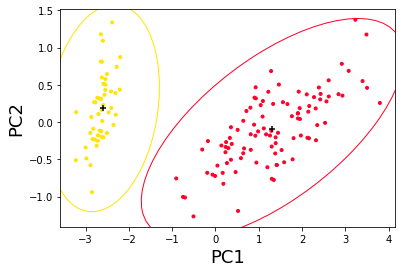

In [14]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Parametric sensitivity

### Compute derivatives

In [15]:
use_free_alpha = True
prior_alpha0 = prior_params_paragami['alpha'].flatten(prior_params_dict['alpha'], free = use_free_alpha)

In [16]:
prior_alpha0

DeviceArray([1.25276297], dtype=float64)

In [17]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['alpha'] = alpha
    
    return gmm_lib.get_kl(features, vb_params_dict, _prior_params_dict,
                    gh_loc, gh_weights).squeeze()


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])

In [18]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        prior_alpha0)

Compiling ...
Compile time: 104.659sec



In [19]:
# double check the timing ... 

# cross hessian time
cross_hess = vb_sens.dobj_dhyper_dinput(vb_sens.opt_par_value, vb_sens.hyper_par_value0).block_until_ready()
%timeit vb_sens.dobj_dhyper_dinput(vb_sens.opt_par_value, vb_sens.hyper_par_value0).block_until_ready()

197 µs ± 1.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [20]:
# solver time
%timeit vb_sens.hessian_solver(cross_hess.squeeze()).block_until_ready()

138 ms ± 725 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Set new prior

In [21]:
new_alpha = np.array([5.])

In [22]:
lr_vb_free_params = vb_sens.predict_opt_par_from_hyper_par(\
                        prior_params_paragami['alpha'].flatten(new_alpha, free = use_free_alpha))

In [23]:
print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))

l_inf diff:  0.41009823412728963


### Re-optimize

In [24]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [25]:
prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['alpha'] = new_alpha

In [26]:
vb_pert_dict, e_z_pert = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                        vb_params_paragami, prior_params_pert_dict,
                                        gh_loc, gh_weights,
                                       debug = False)

vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)

Compiling CAVI update functions ... 
CAVI compile time: 6.56sec

Running CAVI ... 
done. num iterations = 56
stick_time: 0.681sec
cluster_time: 1.19sec
e_z_time: 0.023sec
**CAVI time: 1.96sec**


### Compare linear response with refitting

In [27]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')

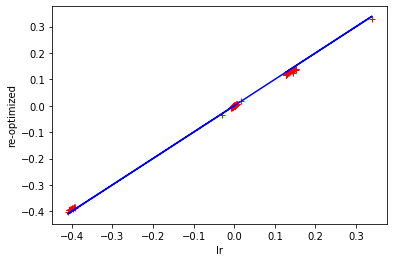

In [28]:
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

# Fit for a range of alpha

In [29]:
alpha_list = np.arange(1, 15)

In [30]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    vb_pert_dict, e_z_pert = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                            vb_params_paragami, prior_params_pert_dict,
                                            gh_loc, gh_weights,
                                           debug = False)

    vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)   
        
    return vb_opt_pert

In [31]:
print('alphas: ', alpha_list)

alphas:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [32]:
vb_pert_list = []
for alpha in alpha_list: 
    print('\n re-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, new_init_dict))


 re-optimzing with alpha =  1
Compiling CAVI update functions ... 
CAVI compile time: 6.56sec

Running CAVI ... 
done. num iterations = 89
stick_time: 1.04sec
cluster_time: 1.21sec
e_z_time: 0.0357sec
**CAVI time: 2.39sec**

 re-optimzing with alpha =  2
Compiling CAVI update functions ... 
CAVI compile time: 6.16sec

Running CAVI ... 
done. num iterations = 59
stick_time: 0.688sec
cluster_time: 0.0555sec
e_z_time: 0.024sec
**CAVI time: 0.837sec**

 re-optimzing with alpha =  3
Compiling CAVI update functions ... 
CAVI compile time: 5.98sec

Running CAVI ... 
done. num iterations = 32
stick_time: 0.375sec
cluster_time: 0.03sec
e_z_time: 0.0138sec
**CAVI time: 0.458sec**

 re-optimzing with alpha =  4
Compiling CAVI update functions ... 
CAVI compile time: 6.12sec

Running CAVI ... 
done. num iterations = 40
stick_time: 0.479sec
cluster_time: 0.038sec
e_z_time: 0.0169sec
**CAVI time: 0.582sec**

 re-optimzing with alpha =  5
Compiling CAVI update functions ... 
CAVI compile time: 6.13s

### Get linear response for each alpha

In [33]:
lr_list = []

for alpha in alpha_list: 
    
    new_alpha = prior_params_paragami['alpha'].flatten(alpha, free = use_free_alpha)
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(new_alpha))

### Print results

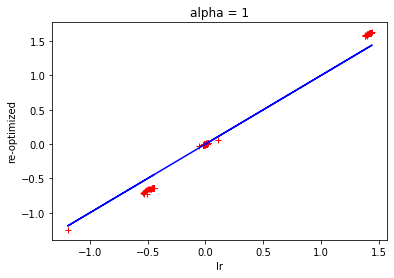

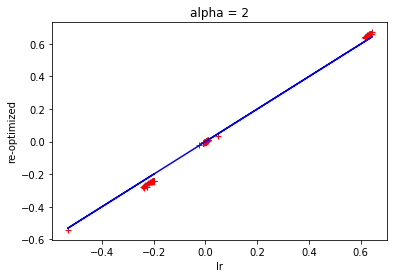

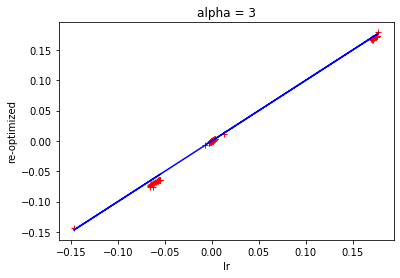

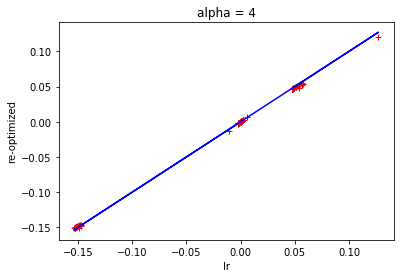

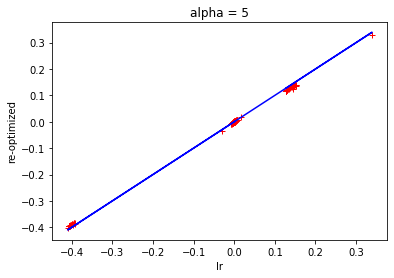

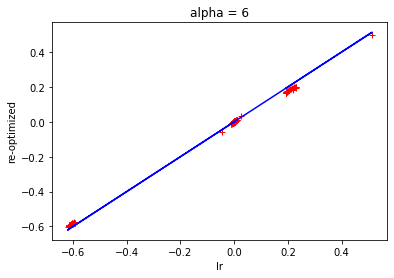

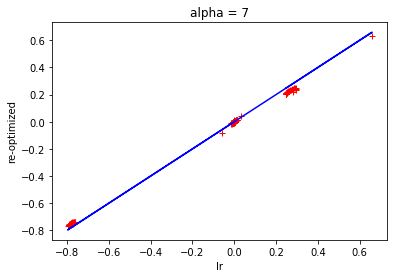

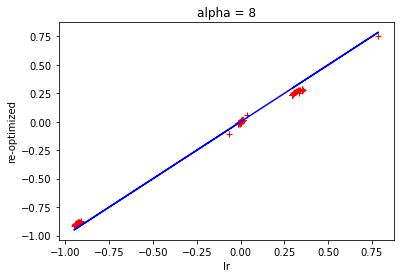

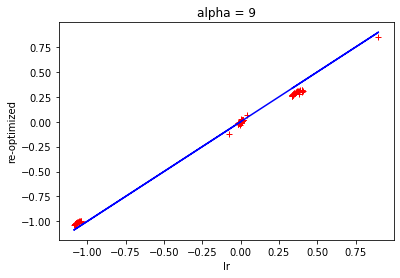

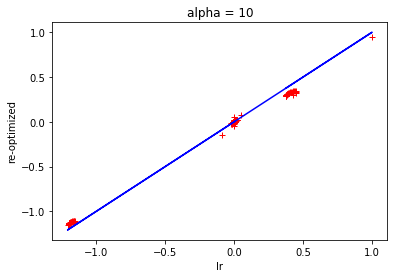

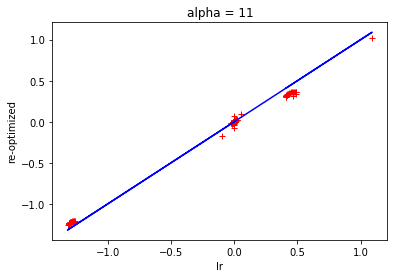

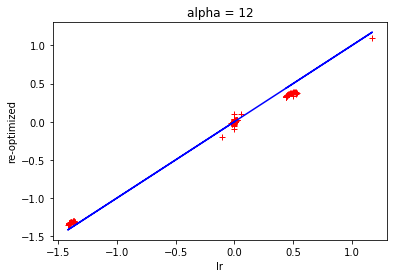

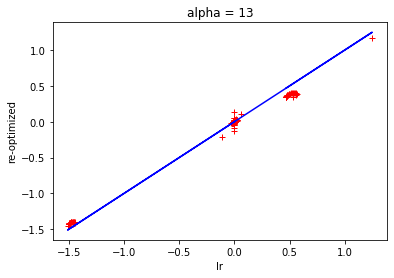

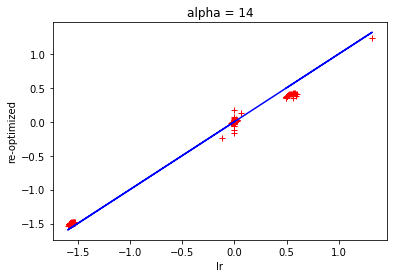

In [34]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))
    

# Check results on number of clusters

### results on number of in-sample clusters

In [43]:
import numpy as onp

In [44]:
threshold = 0

lr_e_num_clusters_vec = onp.zeros(len(alpha_list))
refit_e_num_clusters_vec = onp.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    # number of clusters as predicted by linear response
    lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    lr_list[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 10000, 
                                    # note: the same samples are drawn every loop. 
                                    rng_key = random.PRNGKey(0))
    
    lr_e_num_clusters_vec[i] = lr_e_num_clusters
    
    # number of clusters after refitting 
    refit_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    vb_pert_list[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 10000, 
                                    rng_key = random.PRNGKey(0))
    
    refit_e_num_clusters_vec[i] = refit_e_num_clusters


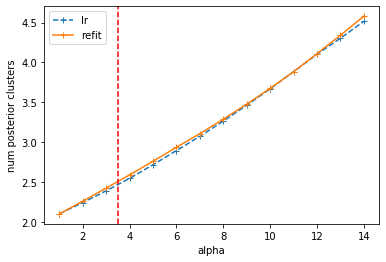

In [45]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')


# Check LR from another alpha

In [46]:
refit_indx = 10
_alpha2 = alpha_list[refit_indx]
print('alpha2: ', _alpha2)

# convert to free parameterization if necessary
alpha2 = prior_params_paragami['alpha'].flatten(_alpha2, free = use_free_alpha)

alpha2:  11


In [47]:
t0 = time.time() 
# reset the derivative 
# this should be fast since we compiled earlier
vb_sens.set_derivatives(vb_pert_list[refit_indx], alpha2)
print(time.time() - t0)

0.13312578201293945


In [48]:
# recompute lr predictions 

lr_list = []

for alpha in alpha_list: 
    
    new_alpha = prior_params_paragami['alpha'].flatten(alpha, free = use_free_alpha)
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(new_alpha))

### Check number of clusters

In [49]:
threshold = 0

lr_e_num_clusters_vec = onp.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    # number of clusters as predicted by linear response
    lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    lr_list[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 10000, 
                                    # note: the same samples are drawn every loop. 
                                    rng_key = random.PRNGKey(0))
    
    lr_e_num_clusters_vec[i] = lr_e_num_clusters

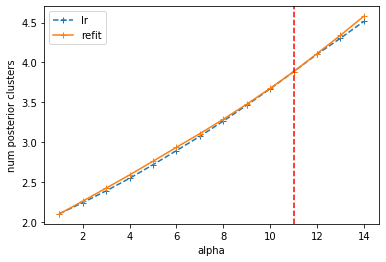

In [50]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(_alpha2, color = 'red', linestyle = 'dashed')